In [1]:
from math import sqrt
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.seasonal import seasonal_decompose

import dask
from multiprocessing import cpu_count
from distributed import Client
#from joblib import Parallel
#from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from load_data import load_data

register_matplotlib_converters()

plt.rc('figure',figsize=(16,12))

## Variables

Variables available:

    - air temp
    - ice concentration
    - ice thickness
    - salinity
    - ocean temp
    
    
Data for ocean is only available from 2019 to roughly present.

In [2]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [3]:
pabrc = load_data_local('station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
weekly = pabrc.resample('W').mean()

<AxesSubplot:>

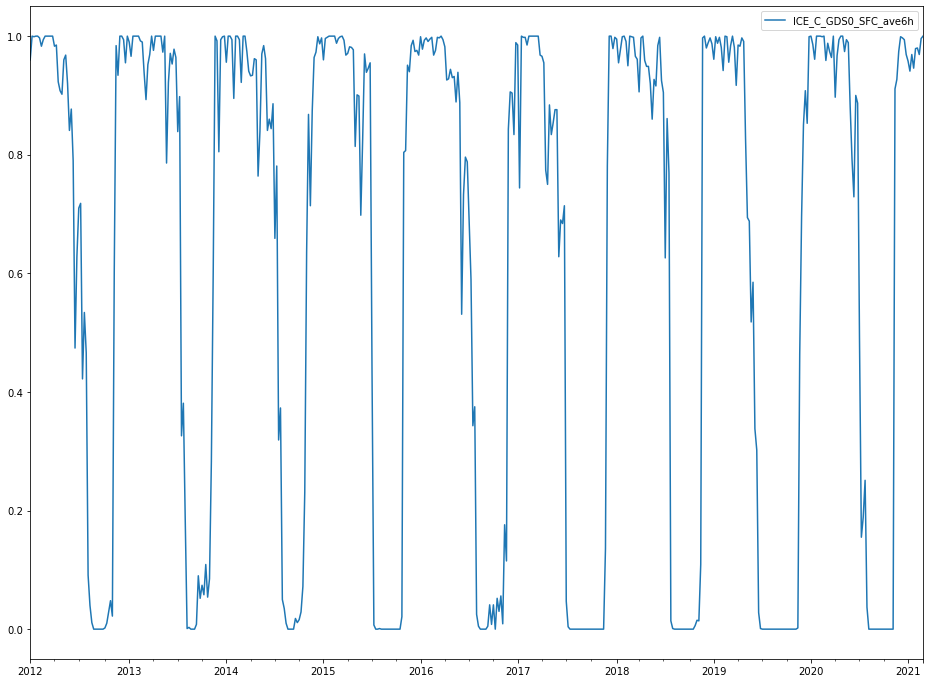

In [4]:
weekly_max = pabrc.resample('W').max()
weekly_max.plot()

<AxesSubplot:>

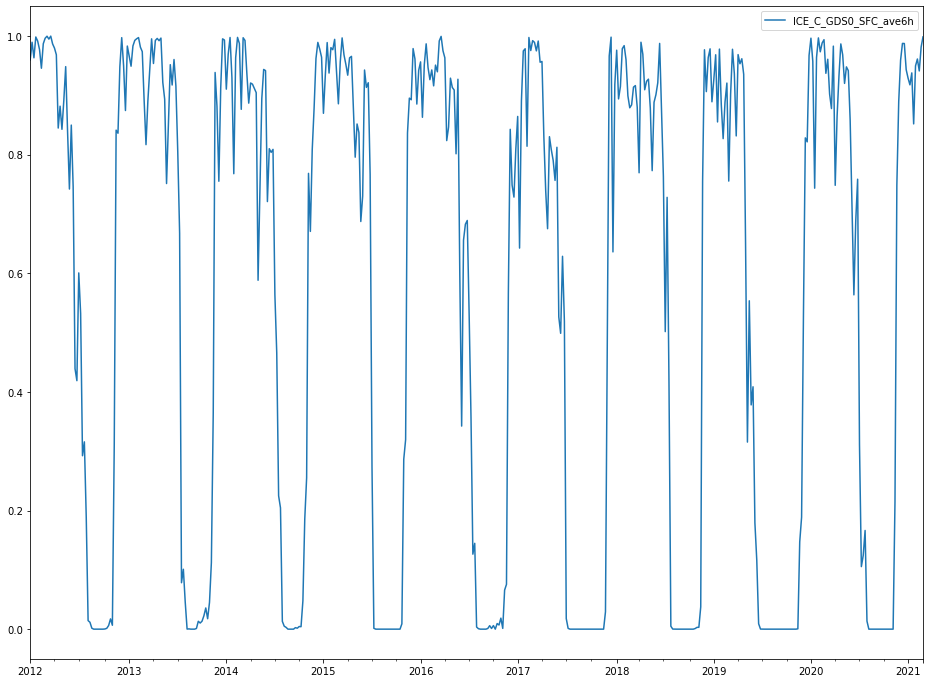

In [5]:
weekly.plot()

In [40]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))

    return yhat[0], model_fit.aic

In [36]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [37]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [41]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat, aic = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [42]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                ilterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [43]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [44]:
 # create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [45]:
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [46]:
n_test = 114
# model configs
cfg_list = sarima_configs(seasonal=[4,12,26,52])
# grid search
#scores = grid_search(weekly.values[:, 0], cfg_list, n_test, parallel=False)
#for cfg, error in scores[:3]:
#    print(cfg, error)

In [47]:
len(cfg_list)

5184

In [48]:
cfg_list[0]

[(0, 0, 0), (0, 0, 0, 4), 'n']

In [49]:
client = Client('estuaries04.ib.axiomptk:9000')

In [50]:
%%time
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, cfg_list[0])
future.result()

CPU times: user 22.1 ms, sys: 5.49 ms, total: 27.6 ms
Wall time: 4.23 s


0.6821030822825941

## Evaluate timings for trend treatment.

| Treatment | time | RMSE |
|  --- | --- | ---  |
'n' | 3.76 | 0.68
'c' |  13 |  0.43
't' | 17.3 | 0.51
'tc'| 33.1 | 0.43


In [19]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 11.5 ms, sys: 7.43 ms, total: 18.9 ms
Wall time: 4.1 s


0.6821030822825941

In [20]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'c'])
future.result()

CPU times: user 21.9 ms, sys: 13.7 ms, total: 35.7 ms
Wall time: 13.1 s


0.43013758372024785

In [21]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 't'])
future.result()

CPU times: user 37.9 ms, sys: 5.58 ms, total: 43.5 ms
Wall time: 17 s


0.5087083158031358

In [22]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'ct'])
future.result()

CPU times: user 60.5 ms, sys: 11.9 ms, total: 72.5 ms
Wall time: 32.2 s


0.4343365232790525

## Evaluate timings for ARIMA treatment.

Options:

- p : Trend autoregression order [0, 1, 2]
- d : Trend difference order [0, 1]
- q : Ttrend moving average order [0, 1, 2]

### Trend Autoregression Order (**p**) [0, 1, 2]

| Treatment | time | RMSE |
|  --- | --- | ---  |
0 | 4.06 | 0.68
1 |  8.78 |  0.12
2 | 10.4 | 0.12


In [23]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(1, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 20 ms, sys: 7.72 ms, total: 27.7 ms
Wall time: 9.31 s


0.12028608052744813

In [24]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(2, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 20.6 ms, sys: 8.5 ms, total: 29.2 ms
Wall time: 10.4 s


0.11913316670675397

In [25]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(3, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 31 ms, sys: 6.61 ms, total: 37.6 ms
Wall time: 13.8 s


0.1195268920261232

### Trend Autoregression Order (**d**) [0, 1, 2]

| Treatment | time | RMSE |
|  --- | --- | ---  |
0 | 4.06 | 0.68
1 |  8.78 |  0.12
2 | 10.4 | 0.12

In [32]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 15.5 ms, sys: 9.4 ms, total: 24.9 ms
Wall time: 4.06 s


0.6821030822825941

In [35]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 1, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 39 ms, sys: 1.93 ms, total: 40.9 ms
Wall time: 8.25 s


0.12061530955179867

In [36]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 2, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 37.1 ms, sys: 3.03 ms, total: 40.2 ms
Wall time: 8.21 s


0.1575991887208081

### Trend Autoregression Order (**q**) [0, 1, 2]

| Treatment | time | RMSE |
|  --- | --- | ---  |
0 | n/a | 0.68
1 |  11.1 |  0.38
2 | 17.8 | 0.25

In [56]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 22.9 ms, sys: 4.09 ms, total: 27 ms
Wall time: 4.19 s


0.6821030822825941

In [42]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 1), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 45.5 ms, sys: 7.05 ms, total: 52.6 ms
Wall time: 11.1 s


0.3839154552077923

In [43]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 2), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 56.6 ms, sys: 10.9 ms, total: 67.5 ms
Wall time: 17.8 s


0.25309147818283145

### Most accurate ARIMA combinations.


Use (0, 1, 1) 'n'

| Treatment | time | RMSE |
|  --- | --- | ---  |
a | 8.54 | 0.12
b | 17.4 | 0.12
c | 31.4 | 0.12
d | 83 | 0.12

In [45]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 1, 1), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 24.3 ms, sys: 15.7 ms, total: 40 ms
Wall time: 8.54 s


0.11971325368858786

In [46]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 1, 2), (0, 0, 0, 52), 'n'])
future.result()

CPU times: user 54.4 ms, sys: 10.3 ms, total: 64.7 ms
Wall time: 17.4 s


0.11996242966588046

In [47]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 1, 2), (0, 0, 0, 52), 'c'])
future.result()

CPU times: user 99.4 ms, sys: 14.9 ms, total: 114 ms
Wall time: 31.4 s


0.12010815861371704

In [48]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 2, 2), (0, 0, 0, 52), 'c'])
future.result()

CPU times: user 233 ms, sys: 53.6 ms, total: 286 ms
Wall time: 1min 23s


0.12019389226371707

In [61]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(2, 2, 0), (0, 0, 0, 52), 'c'])
future.result()

CPU times: user 74.8 ms, sys: 12.2 ms, total: 87 ms
Wall time: 19.5 s


0.1327002226645763

## Evaluate timings for Seasonal treatment.

Options:

- P : Trend autoregression order [0, 1, 2]
- D : Trend difference order [0, 1]
- Q : Ttrend moving average order [0, 1, 2]

Spendy!

| Treatment | time | RMSE |
|  --- | --- | ---  |
a | 13.9 | 0.43
b | 544  | 0.28
c | 7550 | 0.17
d | 192  | 0.29
e | 469  | 0.38
f | 6338 | 0.14

In [55]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 0, 52), 'c'])
future.result()

CPU times: user 55.8 ms, sys: 7.35 ms, total: 63.1 ms
Wall time: 13.9 s


0.43013758372024785

In [50]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (1, 0, 0, 52), 'c'])
future.result()

CPU times: user 1.75 s, sys: 180 ms, total: 1.93 s
Wall time: 9min 4s


0.2834618118999078

In [51]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (2, 0, 0, 52), 'c'])
future.result()

CPU times: user 26.3 s, sys: 2.14 s, total: 28.4 s
Wall time: 2h 5min 50s


0.1744508624168331

In [52]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 1, 0, 52), 'c'])
future.result()

CPU times: user 727 ms, sys: 38.5 ms, total: 766 ms
Wall time: 3min 12s


0.2966605892212542

In [53]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 0, 0), (0, 0, 1, 52), 'c'])
future.result()

CPU times: user 1.72 s, sys: 120 ms, total: 1.84 s
Wall time: 7min 39s


0.38923823855446704

In [54]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(1, 1, 1), (1, 1, 1, 52), 't'])
future.result()

CPU times: user 22.7 s, sys: 2.15 s, total: 24.8 s
Wall time: 1h 45min 38s


0.13508800249013106

In [67]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(1, 1, 0), (1, 0, 0, 4), 'c'])
future.result()

CPU times: user 113 ms, sys: 14 ms, total: 127 ms
Wall time: 29.9 s


0.11868834287801192

In [68]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(1, 1, 0), (1, 0, 0, 12), 'c'])
future.result()

CPU times: user 174 ms, sys: 14.3 ms, total: 188 ms
Wall time: 47.2 s


0.11994776734091905

In [69]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(1, 1, 0), (1, 0, 0, 26), 'c'])
future.result()

CPU times: user 445 ms, sys: 45.8 ms, total: 491 ms
Wall time: 2min 7s


0.11815621957890517

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [27]:
%%time
# p,d,q P,D,Q,m, 't'
future = client.submit(walk_forward_validation, weekly.values[:, 0], n_test, [(0, 1, 0), (1, 0, 0, 52), 'c'])
future.result()

CPU times: user 11.4 ms, sys: 1.57 ms, total: 13 ms
Wall time: 13.2 ms


0.12001758398077801